# Importing Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools 
import statsmodels.api as sm
import statsmodels.tsa.api as smt 
import sys
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
user = pd.read_csv('/content/drive/Othercomputers/My Laptop/studi independen/final project/Dataset Final Project DBA/marketing_data/user_data.csv')
event = pd.read_csv('/content/drive/Othercomputers/My Laptop/studi independen/final project/Dataset Final Project DBA/marketing_data/event_data.csv')
product_view = pd.read_csv('/content/drive/Othercomputers/My Laptop/studi independen/final project/Dataset Final Project DBA/marketing_data/product_view_data.csv')

# Data Exploration & Data Cleaning

## User Data

In [ ]:
user.head(5)

,id,age,gender,country,traffic_source,date_created_at
0,19279,50,F,Japan,Search,2020-11-07
1,5678,58,M,Brasil,Email,2019-07-28
2,29694,60,M,Brasil,Facebook,2019-08-16
3,29967,12,M,Brasil,Search,2019-05-09
4,47096,68,F,Brasil,Search,2019-05-24


Untuk melakukan data cleaning kita harus mengetahui bagaimana kualitas dataset user kita terlebih dahulu

In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               100000 non-null  int64 
 1   age              100000 non-null  int64 
 2   gender           100000 non-null  object
 3   country          100000 non-null  object
 4   traffic_source   100000 non-null  object
 5   date_created_at  100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


In [ ]:
for feature in ['gender', 'country', 'traffic_source']:
  if user[feature].any():
    print(f"num of unique values in {feature}: ", user[feature].unique())

num of unique values in gender:  ['F' 'M']
num of unique values in country:  ['Japan' 'Brasil' 'United States' 'China' 'South Korea' 'Spain' 'France'
 'United Kingdom' 'Germany' 'Colombia' 'Belgium' 'Poland' 'Australia'
 'Austria' 'España']
num of unique values in traffic_source:  ['Search' 'Email' 'Facebook' 'Organic' 'Display']


Dapat dilihat pada dataset user tidak terdapat null values. Namun pada tipe data pada kolom date_created_at masih belum tepat. Kita harus merubah tipe datanya menjadi datetime. Kita juga akan menghapus duplikat pada dataset ini berdasarkan kolom id nya. Selain itu pada kolom country ada value Espana yang merupakan bahasa latin dari Spain yang perlu kita rubah. Pada kolom traffic source juga ada nilai Search yang bisa menciptakan kebingungan dengan nilai Organic. Berdasarkan dataset event value ini memiliki arti yang sama dengan Adwords. Oleh karena itu kita akan mengganti value Search menjadi Adwords.

In [ ]:
user['date_created_at']=pd.to_datetime(user['date_created_at'])

In [ ]:
user = user.drop_duplicates(subset = 'id')

In [ ]:
user.loc[user["country"] == "España", "country"] = 'Spain'
user.loc[user["traffic_source"] == "Search", "traffic_source"] = 'Adwords'

In [ ]:
for feature in ['gender', 'country', 'traffic_source']:
  if user[feature].any():
    print(f"num of unique values in {feature}: ", user[feature].unique())

num of unique values in gender:  ['F' 'M']
num of unique values in country:  ['Japan' 'Brasil' 'United States' 'China' 'South Korea' 'Spain' 'France'
 'United Kingdom' 'Germany' 'Colombia' 'Belgium' 'Poland' 'Australia'
 'Austria']
num of unique values in traffic_source:  ['Adwords' 'Email' 'Facebook' 'Organic' 'Display']


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               100000 non-null  int64         
 1   age              100000 non-null  int64         
 2   gender           100000 non-null  object        
 3   country          100000 non-null  object        
 4   traffic_source   100000 non-null  object        
 5   date_created_at  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 5.3+ MB


## Event Data

Pertama-tama kita harus mengecek kualitas dataset event terlebih dahulu

In [ ]:
event.head()

,id,user_id,session_id,date_created_at,browser,traffic_source,event_type
0,996150,77383.0,0a019a15-5597-42e1-9957-a80f22a90c7b,2022-05-27,Chrome,Email,home
1,999739,77633.0,96bf5283-5f21-4cc1-948f-420ca6b4e20a,2022-02-23,Chrome,Email,home
2,1004976,78025.0,98594520-717e-4654-a5e4-b12d7226364c,2021-12-06,Firefox,Email,home
3,1007220,78190.0,9e8da74d-98fe-4ed0-a096-2b01d3cf28d8,2021-09-01,Chrome,Email,home
4,1008410,78272.0,e8290b27-4dc9-4d3e-a1b8-3ab897efb016,2020-11-09,Safari,Email,home


In [ ]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418734 entries, 0 to 2418733
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   user_id          float64
 2   session_id       object 
 3   date_created_at  object 
 4   browser          object 
 5   traffic_source   object 
 6   event_type       object 
dtypes: float64(1), int64(1), object(5)
memory usage: 129.2+ MB


In [ ]:
event.isnull().sum()

id                       0
user_id            1125498
session_id               0
date_created_at          0
browser                  0
traffic_source           0
event_type               0
dtype: int64

Dapat dilihat pada kolom user_id terdapat missing values yang sangat banyak. Kita perlu meneliti lebih jauh penyebab missing values pada kolom ini

In [ ]:
null_user = event[event.user_id.isnull()]
null_user.head()

,id,user_id,session_id,date_created_at,browser,traffic_source,event_type
479,1293991,NaN,ab87143c-3aa4-42c1-a50d-79d85459aa53,2019-11-07,Safari,Email,product
480,1294091,NaN,0615c3c1-033a-4926-a9a4-668ced8b2468,2020-06-14,Chrome,Email,product
481,1294625,NaN,b7aba4cd-a2ab-4229-a616-4c0b93974fdc,2020-07-19,Firefox,Email,product
482,1296744,NaN,05a3fd9a-996f-48b8-874f-d545240af2be,2020-10-07,Chrome,Email,product
483,1298187,NaN,5bf0cbdd-d4d3-44d6-8745-864307077159,2020-07-27,Chrome,Email,product


Berdasarkan potongan tabel diatas dapat diambil kesimpulan bahwa nilai null pada kolom user_id menandakan pengunjung website yang belum melakukan login pada website kita. Oleh karena itu kita dapat impute nilai null tersebut dengan anonymous visitor

In [ ]:
event['user_id'] = event.user_id.fillna('anonymous visitor')

Selanjutnya pada kolom date_created_at tipe datanya masih salah. Kita akan mengganti tipe datanya menjadi datetime. Lalu kita akan menghapus data duplikat berdasarkan kolom id

In [ ]:
event['date_created_at']=pd.to_datetime(event['date_created_at'])

In [ ]:
event = event.drop_duplicates(subset = 'id')

In [ ]:
event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2418734 entries, 0 to 2418733
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   user_id          object        
 2   session_id       object        
 3   date_created_at  datetime64[ns]
 4   browser          object        
 5   traffic_source   object        
 6   event_type       object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 147.6+ MB


In [ ]:
event.isnull().sum()

id                 0
user_id            0
session_id         0
date_created_at    0
browser            0
traffic_source     0
event_type         0
dtype: int64

## Product View Data

Selanjutnya kita akan melihat kualitas dataset pada dataset product view

In [ ]:
product_view.head()

,id,user_id,session_id,date_created_at,traffic_source,product_id,product_name,product_category,product_brand
0,1293991,NaN,ab87143c-3aa4-42c1-a50d-79d85459aa53,2019-11-07,Email,4933,Levi's Women's Plus-Size High Rise Jegging,Women's Jeans,Levi's
1,1294091,NaN,0615c3c1-033a-4926-a9a4-668ced8b2468,2020-06-14,Email,14961,Maternity Multicolored Horizontal Striped Cowl...,Women's Maternity,FineBrandShop
2,1294625,NaN,b7aba4cd-a2ab-4229-a616-4c0b93974fdc,2020-07-19,Email,2250,Cactus Fashion Rhinestone Accented Colorfully ...,Women's Fashion Hoodies & Sweatshirts,Cactus Fashion
3,1296744,NaN,05a3fd9a-996f-48b8-874f-d545240af2be,2020-10-07,Email,21797,Lucky Brand 361 Vintage Straight Men's Corduro...,Men's Pants,Lucky Brand
4,1298187,NaN,5bf0cbdd-d4d3-44d6-8745-864307077159,2020-07-27,Email,10570,Maidenform Women's Pressure Free Underwire Bra,Women's Intimates,Maidenform


In [ ]:
product_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841886 entries, 0 to 841885
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                841886 non-null  int64  
 1   user_id           341886 non-null  float64
 2   session_id        841886 non-null  object 
 3   date_created_at   841886 non-null  object 
 4   traffic_source    841886 non-null  object 
 5   product_id        841886 non-null  int64  
 6   product_name      841825 non-null  object 
 7   product_category  841886 non-null  object 
 8   product_brand     841204 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 57.8+ MB


In [ ]:
product_view.isna().sum()

id                       0
user_id             500000
session_id               0
date_created_at          0
traffic_source           0
product_id               0
product_name            61
product_category         0
product_brand          682
dtype: int64

Dapat dilihat pada kolom user_id, product_name, dan product_brand terdapat missing values. Kita akan melakukan impute pada kolom tersebut untuk mengisi nilai nullnya

In [ ]:
product_view['user_id'] = product_view.user_id.fillna('anonymous visitors')
product_view['product_name'] = product_view.product_name.fillna('unrecorded')
product_view['product_brand'] = product_view.product_brand.fillna('unrecorded')

Selanjutnya kita juga akan mengganti tipe data pada kolom date_created_at menjadi datetime dan menghapus data duplikat berdasarkan kolom id

In [ ]:
product_view['date_created_at']=pd.to_datetime(product_view['date_created_at'])

In [ ]:
product_view = product_view.drop_duplicates(subset = 'id')

In [ ]:
product_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841886 entries, 0 to 841885
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                841886 non-null  int64         
 1   user_id           841886 non-null  object        
 2   session_id        841886 non-null  object        
 3   date_created_at   841886 non-null  datetime64[ns]
 4   traffic_source    841886 non-null  object        
 5   product_id        841886 non-null  int64         
 6   product_name      841886 non-null  object        
 7   product_category  841886 non-null  object        
 8   product_brand     841886 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 64.2+ MB


# Explanatory Data Analysis

## User Dataset

### Descriptive Analysis

In [ ]:
print(user.describe().T.round(2))
print('-------------')
print(user.filter(['gender', 'country', 'traffic_source', 'date_created_at']).describe())

        count      mean       std   min       25%      50%       75%       max
id   100000.0  50000.50  28867.66   1.0  25000.75  50000.5  75000.25  100000.0
age  100000.0     41.06     17.00  12.0     26.00     41.0     56.00      70.0
-------------
        gender country traffic_source      date_created_at
count   100000  100000         100000               100000
unique       2      14              5                 1247
top          F   China        Adwords  2022-06-01 00:00:00
freq     50053   34001          70181                  493
first      NaN     NaN            NaN  2019-01-02 00:00:00
last       NaN     NaN            NaN  2022-06-01 00:00:00


Dari summary statistic diatas beberapa hal yang dapat kita simpulkan yaitu:
*   Rata-rata usia user kita yaitu 41.06 tahun dengan user termuda berusia 12 tahun dan user tertua berusia 70 tahun
*   Mayoritas user adalah wanita
*   Mayoritas user berasal dari China
*   Traffic source mayoritas user yaitu adwords pada search engine
* User pertama terdaftar pada tanggal 2 Januari 2019 dan dan registrasi user terakhir terjadi pada 1 Juni 2022 





Berikutnya kita akan melihat distribusi data user berdasarkan fitur kategorikalnya. Pertama-tama kita akan membuat age group. Kita akan membuat fungsi pada yang akan mengklasifikasikan user kita ke kelompok usia berdasarkan usianya. 

In [ ]:
def age_group(row):
  if row.age >= 12 and row.age <=17:
    return 'Teens (12-17)'
  if row.age >= 18 and row.age <=30:
    return 'Young Adult (18-30)'
  if row.age >= 31 and row.age <= 55:
    return 'Adult (31-55)'
  if row.age > 55:
    return 'Senior Adult (56 and older)' 

Setelah itu kita perlu menerapkan fungsi tersebut kedalam dataset user

In [ ]:
user['age_group'] = user.apply(age_group, axis = 1)
user.head(3)

,id,age,gender,country,traffic_source,date_created_at,age_group
0,19279,50,F,Japan,Adwords,2020-11-07,Adult (31-55)
1,5678,58,M,Brasil,Email,2019-07-28,Senior Adult (56 and older)
2,29694,60,M,Brasil,Facebook,2019-08-16,Senior Adult (56 and older)


Untuk mempermudah visualisasi distribusi data, maka akan dibuat fungsi plot_count untuk mempersingkat penulisan syntaxnya.

In [ ]:
def plot_count(data, x=None, y=None, palette=None, figsize=(12, 6), **kwargs):
    column_order = data[x or y].value_counts().index

    plt.figure(figsize=figsize)
    sns.countplot(
        x=x, y=y, data=data, order=column_order,
        palette=palette, **kwargs
    )
    plt.grid(False)

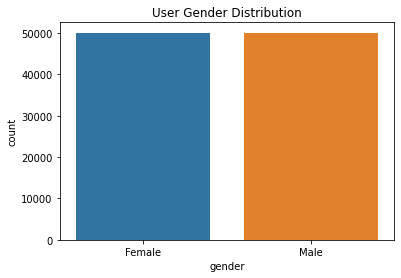

In [ ]:
plot_count(data = user, x = "gender", figsize=(6,4))
plt.xticks([0, 1], ["Female", "Male"])
plt.title('User Gender Distribution')
plt.show()

Dari visualisasi diatas dapat dilihat bahwa jumlah pengguna pria dan wanita hampir sama

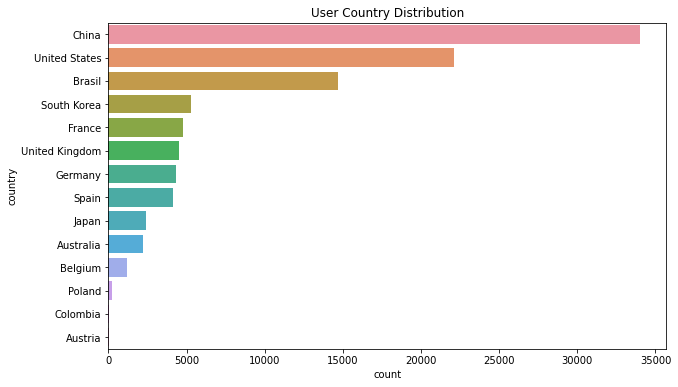

In [ ]:
plot_count(data = user, y = "country", figsize=(10,6))
plt.title('User Country Distribution')
plt.show()

Dari visualisasi diatas dapat dilihat mayoritas dari user berasal dari Cina, Amerika Serikat, dan Brasil

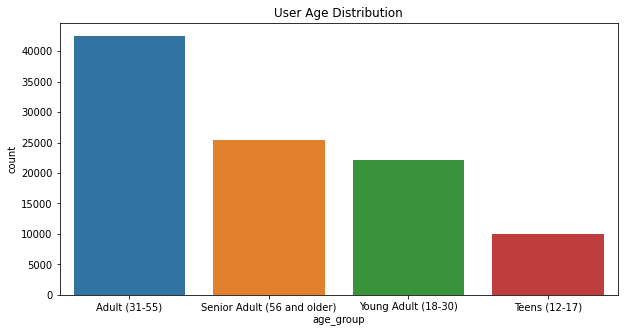

In [ ]:
plot_count(data = user, x = 'age_group', figsize=(10,5))
plt.title('User Age Distribution')
plt.show()

Dari visualisasi diatas diketahui bahwa mayoritas user berada pada kelompok usia dewasa antara 31-60 tahun

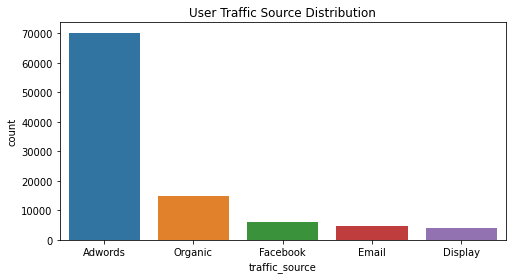

In [ ]:
plot_count(data = user, x = 'traffic_source', figsize=(8,4))
plt.title('User Traffic Source Distribution')
plt.show()

Dari visualisasi diatas diketahui bahwa hampir keseluruhan dari user berasal dari traffic source search atau adwords, sebuah metode online advertisement yang memanfaatkan search engine seperti Google Ads dimana pemilik usaha dapat menawar kata kunci tertentu agar iklan mereka yang dapat diklik muncul di hasil pencarian Google.

Selanjutnya kita akan menganalisa bagaimana tren jumlah user baru yang mendaftar setiap bulannya. Pertama-tama kita akan membuat dataframse berisikan jumlah user baru setiap bulannya dengan kolom date month sebagai index 

In [ ]:
user_copy = user
user_copy.date_created_at = pd.to_datetime(user_copy.date_created_at.values.astype('datetime64[M]'))

monthly_new_user = user_copy.groupby(['date_created_at'])['id'].count().reset_index()
monthly_new_user.columns = ['month', 'total_new_user']
monthly_new_user = monthly_new_user.set_index(['month'])
monthly_new_user = monthly_new_user.drop(index = '2022-06-01')
monthly_new_user.tail()

,total_new_user
month,
2022-01-01,2494
2022-02-01,2128
2022-03-01,2462
2022-04-01,2276
2022-05-01,4512


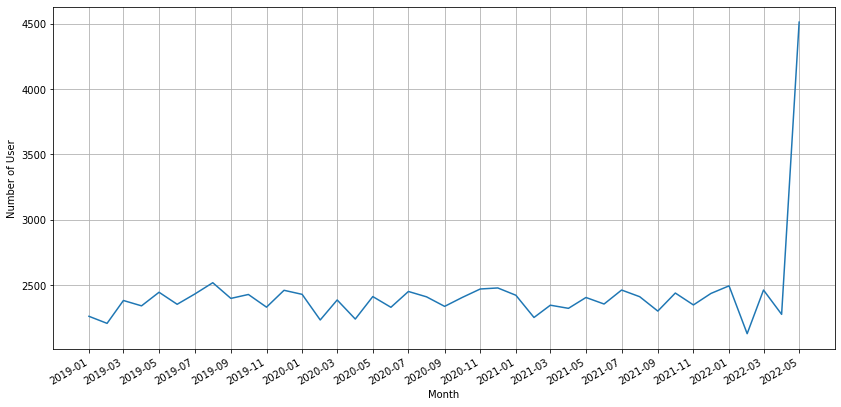

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
plt.xlabel("Month")
plt.ylabel("Number of User")

half_year_locator = mdates.MonthLocator(interval = 2)
year_month_formatter = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

sns.lineplot(data = monthly_new_user, x = 'month', y = 'total_new_user',)

fig.autofmt_xdate()
plt.grid()
plt.show()

* Dari visualisasi diatas dapat dikatakan bahwa pertumbuhan user baru pada website kita cukup stagnan, dengan pengecualian pada bulan 5 tahun 2022 dimana terjadi kenaikan yang sangat signifikan. 
* Berdasarkan grafik tersebut terdapat pola seasonal dalam jumlah user baru di tiap bulannya.
* Namun bagaimana kira-kira pertumbuhan jumlah user baru kedepannya? Untuk menjawab pertanyaan tersebut, kita bisa menggunakan forecasting. Namun sebelum sampai ke tahap pemodelan, kita harus memastikan bahwa data kita stasioner terlebih dahulu

### Stationarity Check

Untuk melakukan stationarity check, kita akan menggunakan Augmented Dickey-Fuller (ADF) test, dimana:

H0: Deret waktu tidak stasioner. Dengan kata lain, ia memiliki beberapa struktur yang bergantung pada waktu dan tidak memiliki varians yang konstan dari waktu ke waktu

H1: Deret waktu stasioner.

**Jika p-value test kurang dari significance level (contoh alpha = 0.05) dan nilai ADF test lebih kecil dibandingkan critical values maka kita dapat reject null hypothesis dan dapat menyimpulkan bahwa time series adalah stasioner.**

In [ ]:
print('Dickey-Fuller Test: ')
dftest=adfuller(monthly_new_user['total_new_user'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('Dickey-Fuller Test: ')
print(dfoutput)

Dickey-Fuller Test: 
Dickey-Fuller Test: 
Test Statistic          -2.703053
p-value                  0.073511
Lags Used                2.000000
No. of Obs              38.000000
Critical Value (1%)     -3.615509
Critical Value (5%)     -2.941262
Critical Value (10%)    -2.609200
dtype: float64


Nilai ADF statistic yang  lebih besar dari critical values pada level 5% dan 1%, dan juga p-value yang lebih besar dari 0.05 turut menandakan, kita gagal menolak null hypothesis yang mengindikasikan bahwa data time series ini tidak stasioner. 

Berdasarkan kesimpulan diatas, kita dapat mencoba menstabilkan variance dengan cara log transformation pada data User dengan np.log()

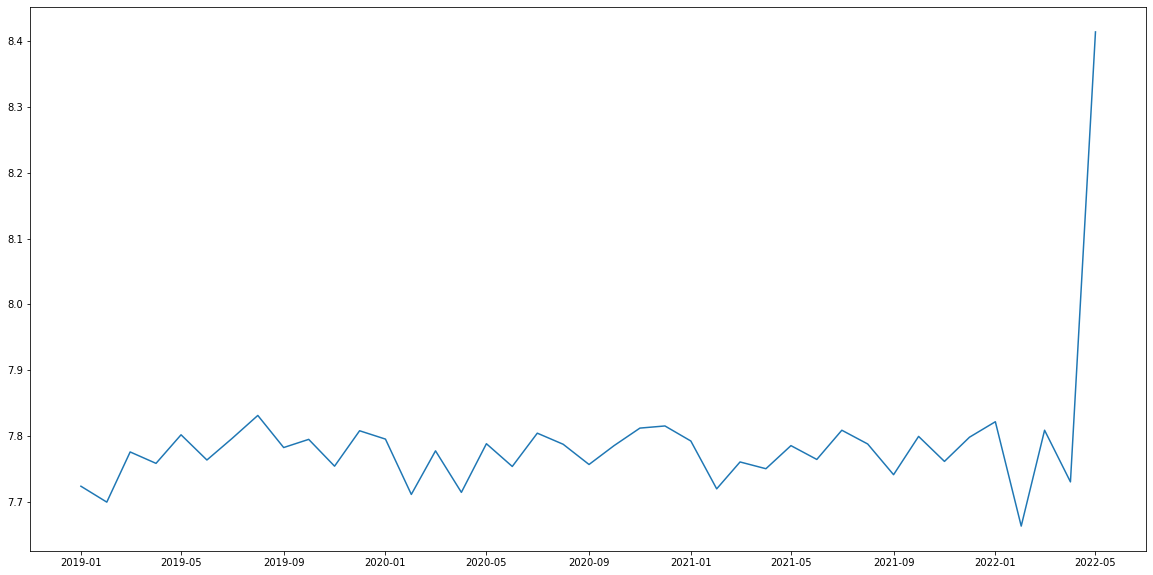

In [ ]:
plt.figure(figsize=(20,10))
data_log=np.log(monthly_new_user) 
plt.plot(data_log)

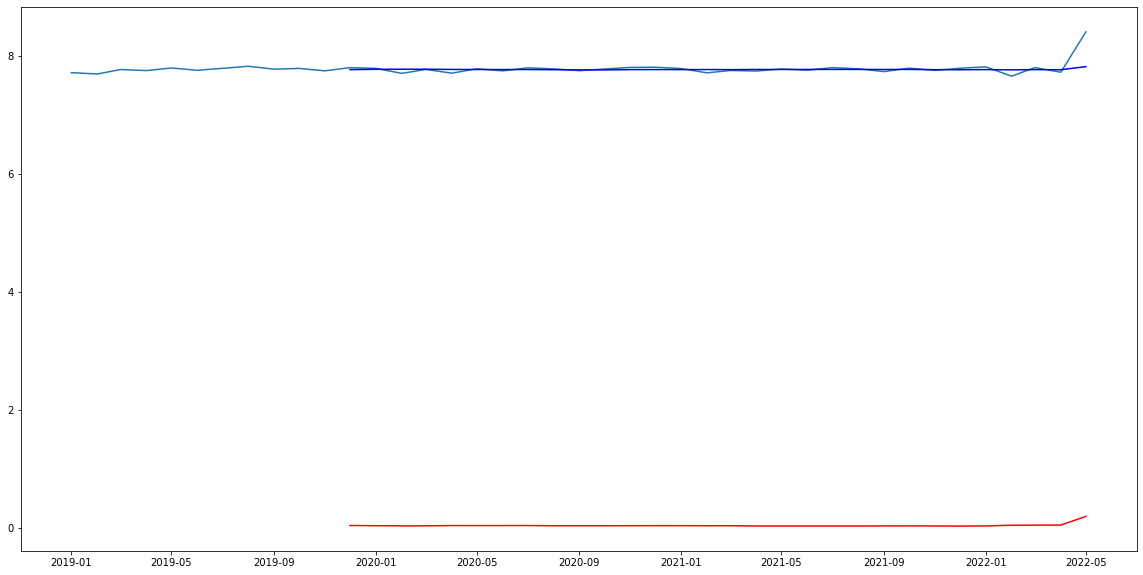

In [ ]:
# Cek secara visual kembali dengan plot data_log dengan rolling window mean dan std. deviation
plt.figure(figsize=(20,10))

MAvg=data_log.rolling(window=12).mean() 
MStd=data_log.rolling(window=12).std()

plt.plot(data_log)
plt.plot(MAvg, color='blue')
plt.plot(MStd, color='red')

In [ ]:
# Hitung difference dari data_log dengan MAvg
data_log_diff=data_log-MAvg

# Tampilkan 12 baris teratas dari data_log_diff
data_log_diff.head(12)

,total_new_user
month,
2019-01-01,NaN
2019-02-01,NaN
2019-03-01,NaN
2019-04-01,NaN
2019-05-01,NaN
2019-06-01,NaN
2019-07-01,NaN
2019-08-01,NaN
2019-09-01,NaN


In [ ]:
# Efek dari rolling di atas, maka akan ada value NaN, sehingga kita bisa lakukan dropna()
data_log_diff=data_log_diff.dropna() 
data_log_diff.head()

,total_new_user
month,
2019-12-01,0.033859
2020-01-01,0.015205
2020-02-01,-0.069905
2020-03-01,-0.003772
2020-04-01,-0.063240


In [ ]:
# Buat function stationarity untuk menampilkan multiple line chart dari actual, rolling mean, dan rolling std.deviasi
# yang juga berisikan hasil tes dari Dickey-Fuller

def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['total_new_user'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

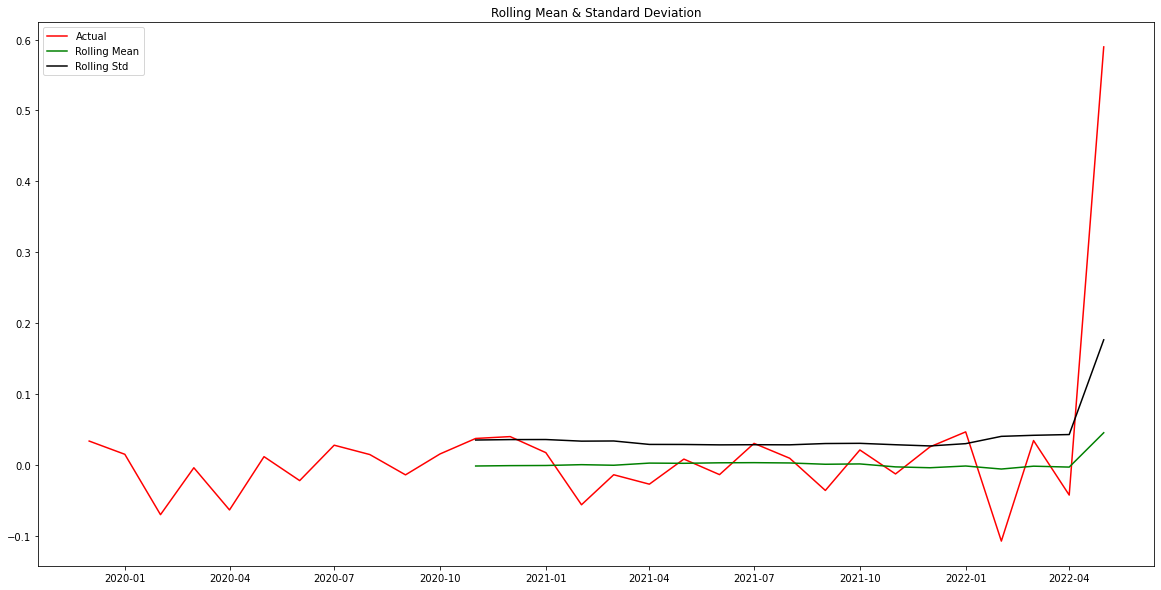

Dickey-Fuller Test: 
Test Statistic          -2.684813
p-value                  0.076703
Lags Used                2.000000
No. of Obs              27.000000
Critical Value (1%)     -3.699608
Critical Value (5%)     -2.976430
Critical Value (10%)    -2.627601
dtype: float64


In [ ]:
# panggil function dan terapkan pada data_log_diff
stationarity(data_log_diff)

Dengan nilai p-value yang masih lebih besar dari 0.05 dan nilai ADF statistic yang lebih besar dari nilai Critical Values pada tingkat kepercayaan 95% dan 99% maka kita masih gagal menolak H0.

Maka, kita dapat mencoba lagi dengan menggunakan Exponentially Weighted Moving Average (function ewm), karena melalui EWM kita dapat memberikan lebih banyak bobot kepada observasi terbaru, dengan kata lain dia akan memberikan bobot lebih sedikit terhadap data yang semakin jauh dari waktu kini, sehingga dia dapat menangkap tren terkini secara lebih cepat

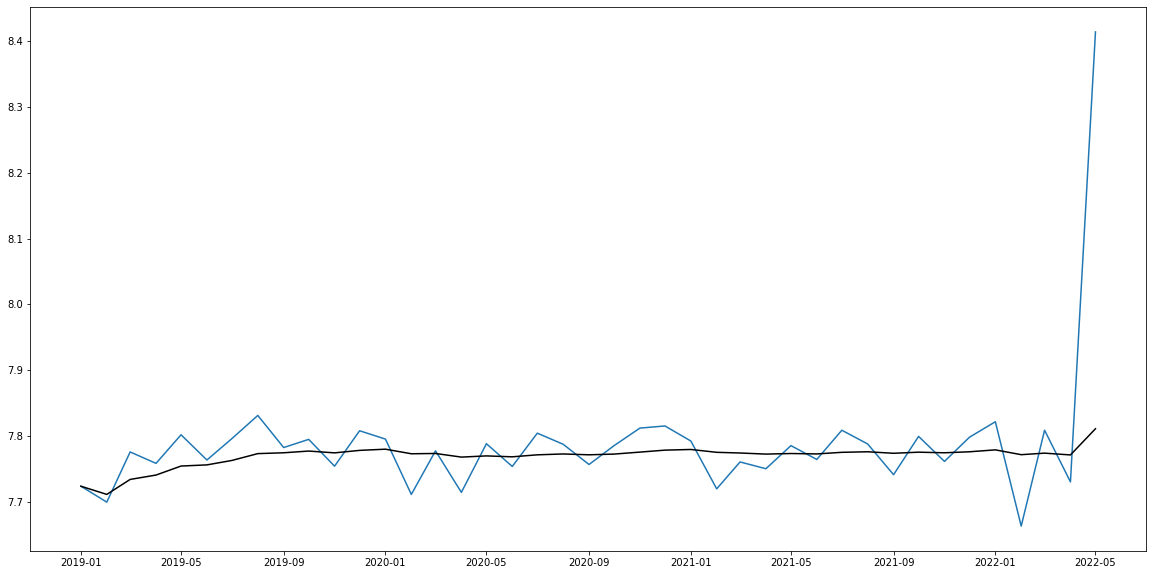

In [ ]:
# Visualisasikan ke dalam bentuk chart 
plt.figure(figsize=(20,10))

# Terapkan function ewm pada data_log melalui variable exp_data
exp_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean() 

plt.plot(data_log)
plt.plot(exp_data, color='black')

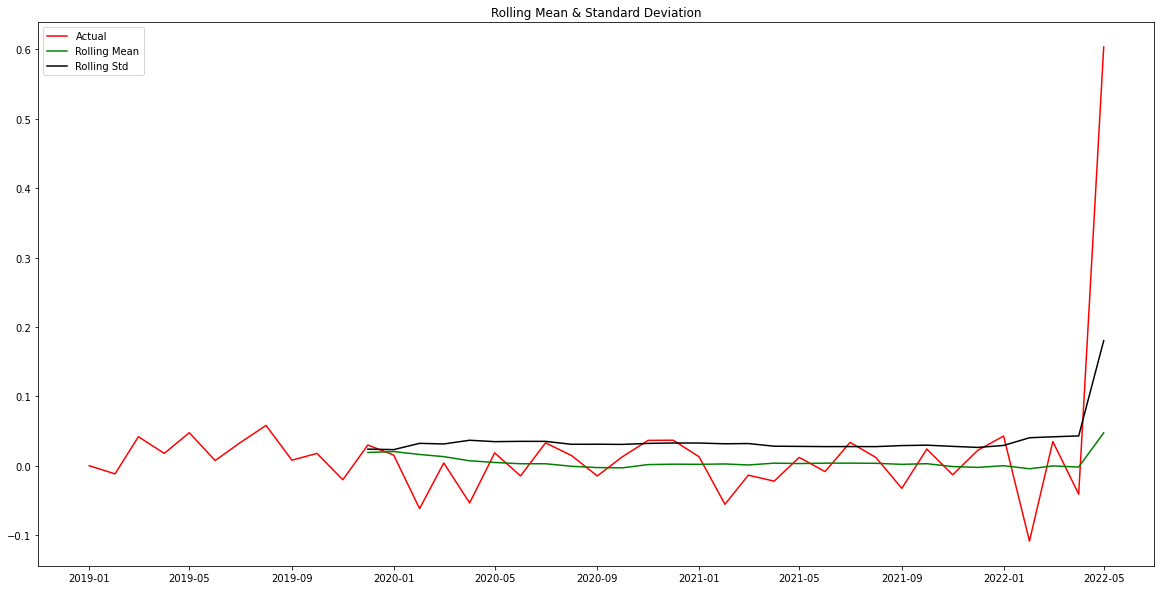

Dickey-Fuller Test: 
Test Statistic          -3.234989
p-value                  0.018047
Lags Used                2.000000
No. of Obs              38.000000
Critical Value (1%)     -3.615509
Critical Value (5%)     -2.941262
Critical Value (10%)    -2.609200
dtype: float64


In [ ]:
# Hitung difference antara data_log dengan exp_data
exp_data_diff=data_log-exp_data

# Panggil function stationarity dan terapkan pada exp_data_diff
stationarity(exp_data_diff)

Kali ini kita berhasil menolak H0 dengan nilai p-value yang lebih kecil dari 0.05 pada tingkat kepercayaan 90% dan 95%. Untuk tingkat kepercayaan 99%, kita masih gagal menolak H0. Maka pada tingkat kepercayaan 90% dan 95% data kita sudah bisa dikatakan stasioner.

### Decomposition

Forecasting menggunakan data historikal dimana diurutkan dengan waktu, sehingga goal dari time series model yaitu untuk menemukan waktu dengan trend, seasonality, dan autocorrelation (correlation over time) lalu diformulasikan menjadi sebuah model.

Teknik Decomposition ini digunakan untuk split data time series menjadi beberapa komponen yaitu trend, seasonality, dan noise (residual) components. Setiap komponen dapat digunakan untuk menunjukkan pola (pattern) yang ada di dalam tiap kategori.

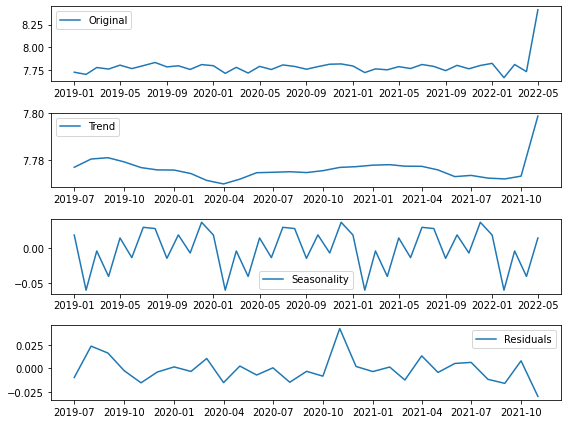

In [ ]:
# panggil function seasonal_decompose () dari statsmodels.tsa yang diterapkan di variabel data_log
decomp=seasonal_decompose(data_log)

# buat variabel trend, seasonal, residual yang sudah diterapkan
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

# Format gambar
plt.figure(figsize = (8,6))
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Dari proses seasonal decompose ditemukan bahwa data kita tidak memiliki tren namun memiliki pola seasonality

In [ ]:
# Tampilkan nilai dari tiap kategori dari 18 baris teratas
print("Trend \n",trend.head(18), '\n') # \n untuk menambahkan baris di akhir
print("Seasonal \n",seasonal.head(18), '\n')
print("Residual \n",residual.head(18), '\n')

Trend 
             total_new_user
month                     
2019-01-01             NaN
2019-02-01             NaN
2019-03-01             NaN
2019-04-01             NaN
2019-05-01             NaN
2019-06-01             NaN
2019-07-01        7.777044
2019-08-01        7.780518
2019-09-01        7.781076
2019-10-01        7.779308
2019-11-01        7.776905
2019-12-01        7.775929
2020-01-01        7.775861
2020-02-01        7.774376
2020-03-01        7.771476
2020-04-01        7.770006
2020-05-01        7.772022
2020-06-01        7.774739 

Seasonal 
             total_new_user
month                     
2019-01-01        0.017870
2019-02-01       -0.059943
2019-03-01       -0.004596
2019-04-01       -0.040542
2019-05-01        0.013763
2019-06-01       -0.013983
2019-07-01        0.028797
2019-08-01        0.027061
2019-09-01       -0.014987
2019-10-01        0.018065
2019-11-01       -0.007429
2019-12-01        0.035922
2020-01-01        0.017870
2020-02-01       -0.059943
2020-03

Dari data residual, kita dapat melihat banyak NA value, maka kita lakukan dropna

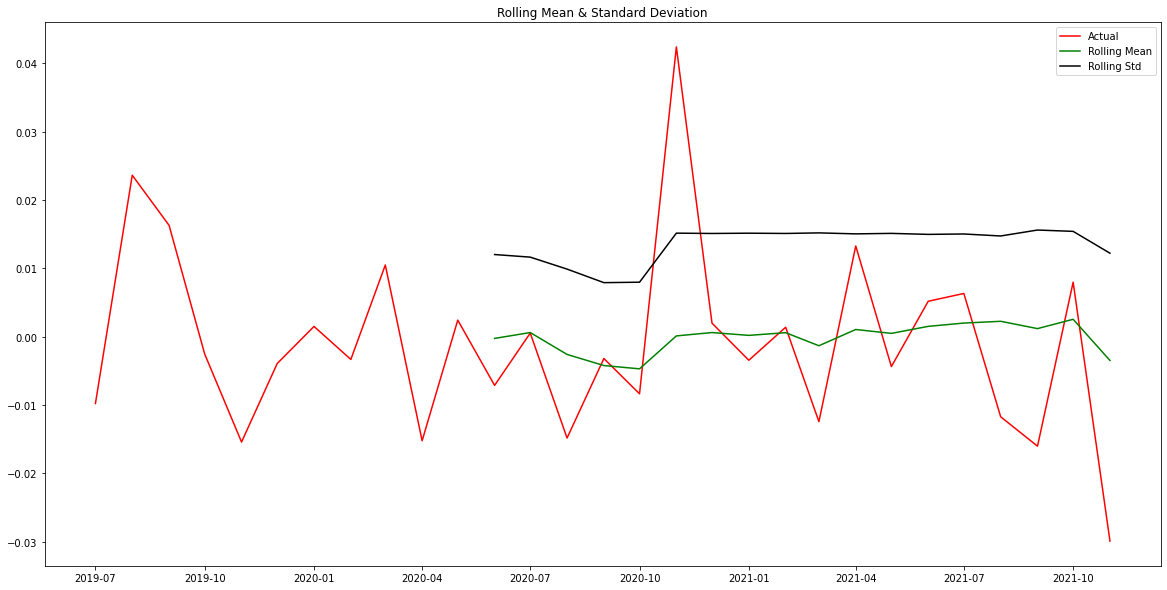

Dickey-Fuller Test: 
Test Statistic          -5.544019
p-value                  0.000002
Lags Used                0.000000
No. of Obs              28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
dtype: float64


In [ ]:
# assign variable baru decomp_data dengan variabel residual di atas
decomp_data=residual

# terapkan function dropna
decomp_data=decomp_data.dropna()

# Panggil function stationarity dan terapkan pada decomp data yang tanpa NA value
stationarity(decomp_data)

Dari komponen data residual, hasil ADF test menunjukkan bahwa bahwa nilai Test statistic yg jauh lebih kecil daripada critical value pd berbagai tingkat keyakinan. Dan p-value yang jauh lebih kecil dari 0.05, kita dapat menyatakan bahwa series ini cukup stasioner.

## Event Dataset

### Descriptive Analysis

In [ ]:
print(event.filter(['user_id', 'session_id', 'browser', 'traffic_source', 'event_type']).describe().T)
print('-----------')
print(event.filter(['date_created_at']).describe().T)
print('-----------')

                  count  unique                                   top     freq
user_id         2418734   79987                     anonymous visitor  1125498
session_id      2418734  680508  67fe7f87-723e-4e12-99f7-4b60c6ea3f82       13
browser         2418734       5                                Chrome  1208058
traffic_source  2418734       5                                 Email  1086031
event_type      2418734       6                               product   841886
-----------
                   count unique        top   freq      first       last
date_created_at  2418734   1252 2022-05-31  18901 2019-01-02 2022-06-06
-----------


Dari summary statistic diatas beberapa hal yang dapat kita simpulkan yaitu:

* Ada 680.508 kunjungan unik ke website selama periode 2 Januari 2019 - 6 Juni 2022
* Mayoritas pengunjung merupakan anonymous visitor
* Event yang paling sering terjadi merupakan event product dimana user melihat halaman suatu produk
* Hampir setengah dari traffic berasal dari email advertising
* Browser paling populer dikalangan pengunjung adalah Chrome 

Berikutnya kita akan coba melihat distribusi data user berdasarkan fitur kategorikalnya. Namun sebelumnya kita akan membuat temporary dataframe untuk menyimpan hanya 1 baris pada setiap kunjungan unik ke website kita berdasarkan kolom sesion_id. Hal ini dilakukan agar kita dapat menghitung jumlah unique visitornya

In [ ]:
unique_visit = event.drop_duplicates(subset = 'session_id')
unique_visit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680508 entries, 0 to 924062
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               680508 non-null  int64         
 1   user_id          680508 non-null  object        
 2   session_id       680508 non-null  object        
 3   date_created_at  680508 non-null  datetime64[ns]
 4   browser          680508 non-null  object        
 5   traffic_source   680508 non-null  object        
 6   event_type       680508 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 41.5+ MB


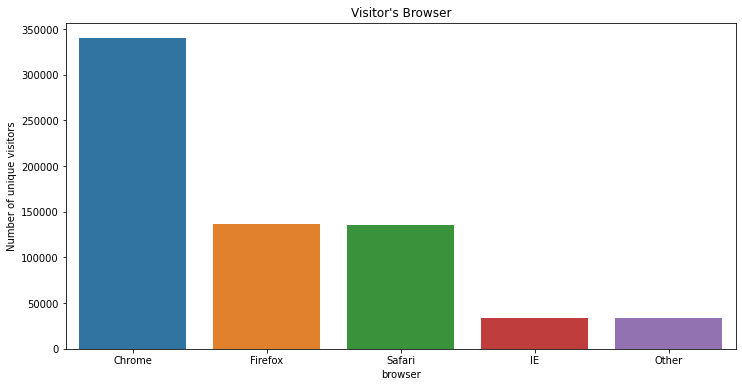

In [ ]:
plot_count(data = unique_visit, x = 'browser', figsize=(12,6))
plt.title("Visitor's Browser")
plt.ylabel("Number of unique visitors")
plt.show()

Dari grafik diatas diketahui bahwa mayoritas pengunjung website menggunakan browser Chrome dibandingkan browser lainnya

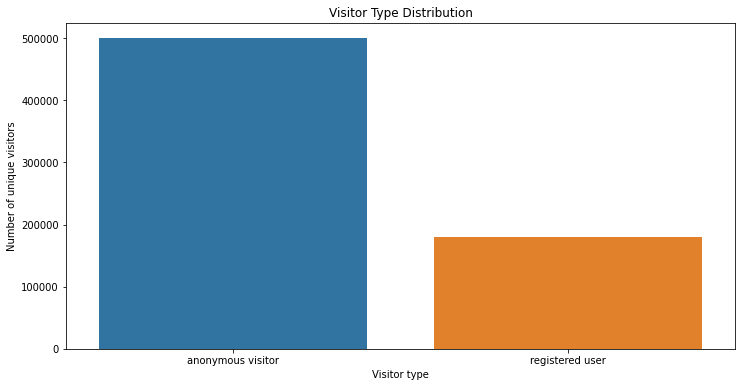

In [ ]:
unique_visit.loc[unique_visit['user_id'] != 'anonymous visitor', 'user_id'] = 'registered user'
plot_count(data = unique_visit, x = 'user_id', figsize=(12,6))
plt.title("Visitor Type Distribution")
plt.xlabel("Visitor type")
plt.ylabel("Number of unique visitors")
plt.show()

Berdasarkan grafik diatas dapat dilihat bahwa mayoritas pengunjung merupakan anonymous visitor atau pengunjung yang tidak melakukan login pada website

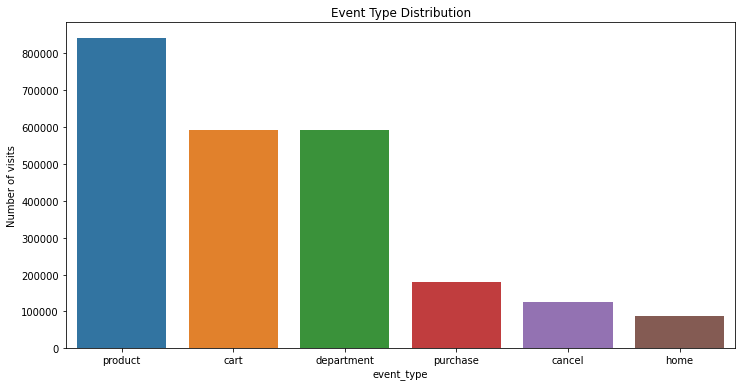

In [ ]:
plot_count(data = event, x = 'event_type', figsize=(12,6))
plt.title("Event Type Distribution")
plt.ylabel("Number of visits")
plt.show()

Kali ini kita kembali menggunakan dataset event untuk melihat aksi yang paling banyak dilakukan pada website kita. Berdasarkan visualisasi tersebut dapat dilihat bahwa event product, cart, dan departmen memiliki nilai yang cukup jauh lebih tinggi dibandingkan dengan tipe event lainnya, terutama tipe event product. Kita juga dapat menganalisa lebih dalam kira-kira produk seperti apa yang sering dilihat dan diminati oleh para pengunjung website kita.

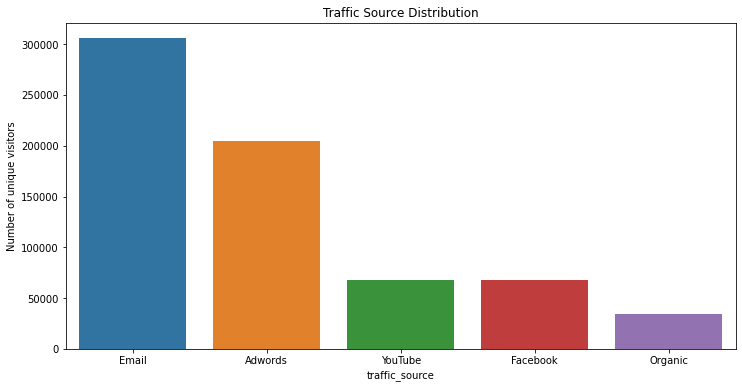

In [ ]:
plot_count(data = unique_visit, x = 'traffic_source', figsize=(12,6))
plt.title("Traffic Source Distribution")
plt.ylabel("Number of unique visitors")
plt.show()

Terakhir kita dapat melihat bahwa sumber yang berhasil menarik mayoritas dari kunjungan ke website yaitu dari email advertising dan adwords

Selanjutnya kita akan menganalisa bagaimana tren jumlah unique visits pada website setiap bulannya. Pertama-tama kita akan membuat dataframse berisikan jumlah unique visits setiap bulannya dengan kolom date month sebagai index

In [ ]:
event_copy = event
event_copy.date_created_at = pd.to_datetime(event_copy.date_created_at.values.astype('datetime64[M]'))

unique_visitors = event_copy.groupby(['date_created_at'])['session_id'].nunique().reset_index()
unique_visitors.columns = ['month', 'unique_visitors']
unique_visitors = unique_visitors.set_index(['month'])
unique_visitors = unique_visitors.drop(index = '2022-06-01')
unique_visitors.tail()

,unique_visitors
month,
2022-01-01,22325
2022-02-01,21049
2022-03-01,25150
2022-04-01,26271
2022-05-01,36756


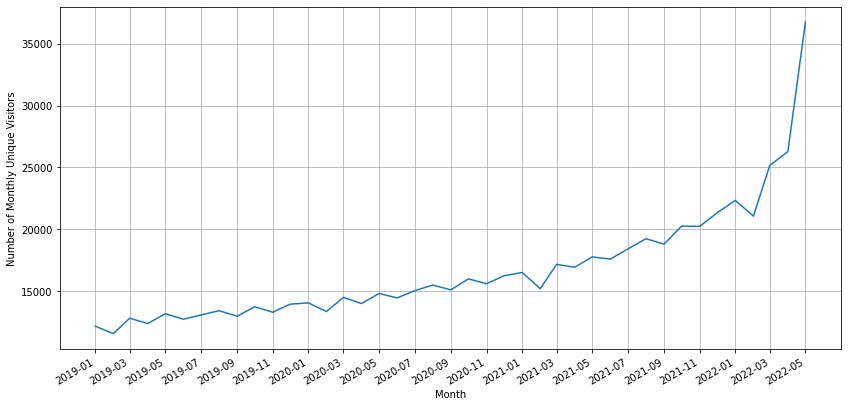

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
plt.xlabel("Month")
plt.ylabel("Number of Monthly Unique Visitors")

half_year_locator = mdates.MonthLocator(interval = 2)
year_month_formatter = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

sns.lineplot(data = unique_visitors, x = 'month', y = 'unique_visitors',)

fig.autofmt_xdate()
plt.grid()
plt.show()

* Dari visualisasi diatas dapat dikatakan bahwa pertumbuhan jumlah kunjungan pada website kita cukup baik. Terdapat tren naik dalam jumlah kunjungan unik di setiap bulannya. 
* Namun bagaimana kira-kira pertumbuhan jumlah kunjungan unik kedepannya? Untuk menjawab pertanyaan tersebut, kita bisa menggunakan forecasting. Sama seperti sebelumnya, sebelum sampai ke tahap pemodelan, kita harus memastikan bahwa data kita stasioner terlebih dahulu

### Stationarity Check

Untuk melakukan stationarity check, kita akan menggunakan Augmented Dickey-Fuller (ADF) test, dimana:

H0: Deret waktu tidak stasioner. Dengan kata lain, ia memiliki beberapa struktur yang bergantung pada waktu dan tidak memiliki varians yang konstan dari waktu ke waktu

H1: Deret waktu stasioner.

**Jika p-value test kurang dari significance level (contoh alpha = 0.05) dan nilai ADF test lebih kecil dibandingkan critical values maka kita dapat reject null hypothesis dan dapat menyimpulkan bahwa time series adalah stasioner.**

In [ ]:
print('Dickey-Fuller Test: ')
dftest=adfuller(unique_visitors['unique_visitors'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('Dickey-Fuller Test: ')
print(dfoutput)

Dickey-Fuller Test: 
Dickey-Fuller Test: 
Test Statistic          -0.695913
p-value                  0.847805
Lags Used                5.000000
No. of Obs              35.000000
Critical Value (1%)     -3.632743
Critical Value (5%)     -2.948510
Critical Value (10%)    -2.613017
dtype: float64


Nilai ADF statistic yang  lebih besar dari critical values pada semua level dan juga p-value yang lebih besar dari 0.05 turut menandakan, kita gagal menolak null hypothesis yang mengindikasikan bahwa data time series ini tidak stasioner. 

Berdasarkan kesimpulan diatas, kita dapat mencoba menstabilkan variance dengan cara log transformation pada data User dengan np.log()

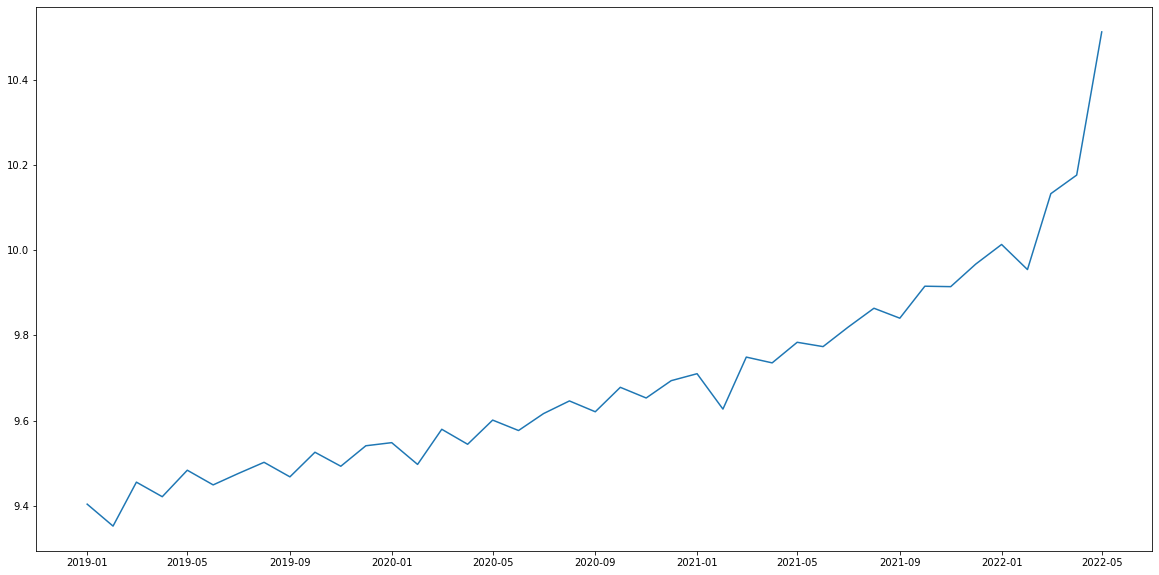

In [ ]:
plt.figure(figsize=(20,10))
data_log=np.log(unique_visitors) 
plt.plot(data_log)

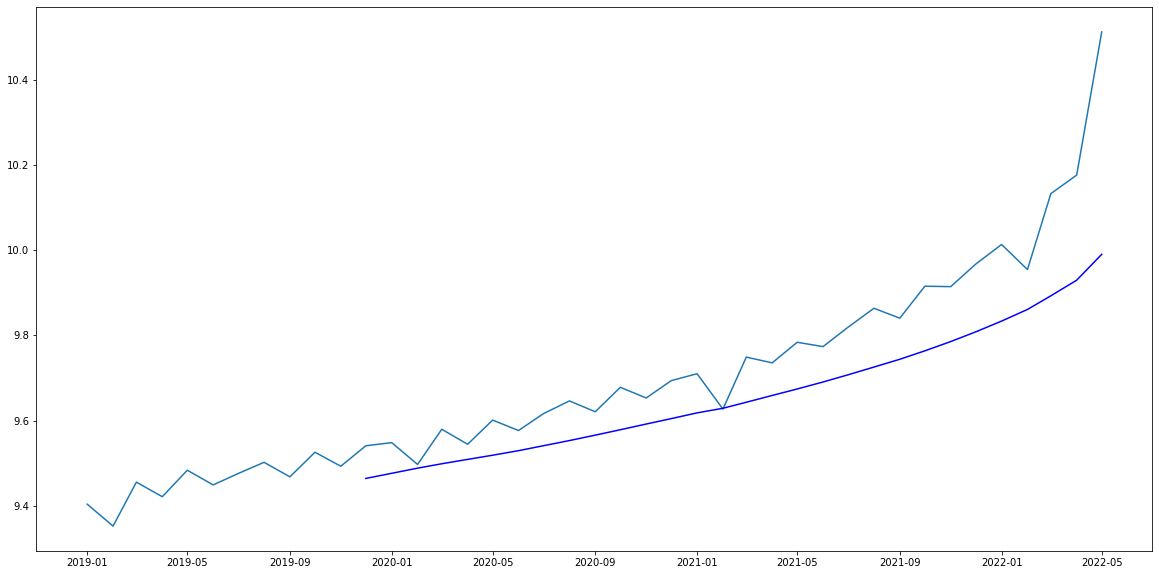

In [ ]:
# Cek secara visual kembali dengan plot data_log dengan rolling window mean dan std. deviation
plt.figure(figsize=(20,10))

MAvg=data_log.rolling(window=12).mean() 
MStd=data_log.rolling(window=12).std()

plt.plot(data_log)
plt.plot(MAvg, color='blue')
#plt.plot(MStd, color='red')

In [ ]:
# Hitung difference dari data_log dengan MAvg
data_log_diff=data_log-MAvg

# Tampilkan 12 baris teratas dari data_log_diff
data_log_diff.head(12)

,unique_visitors
month,
2019-01-01,NaN
2019-02-01,NaN
2019-03-01,NaN
2019-04-01,NaN
2019-05-01,NaN
2019-06-01,NaN
2019-07-01,NaN
2019-08-01,NaN
2019-09-01,NaN


In [ ]:
# Efek dari rolling di atas, maka akan ada value NaN, sehingga kita bisa lakukan dropna()
data_log_diff=data_log_diff.dropna() 
data_log_diff.head()

,unique_visitors
month,
2019-12-01,0.076618
2020-01-01,0.071897
2020-02-01,0.008792
2020-03-01,0.080880
2020-04-01,0.035470


In [ ]:
# Buat function stationarity untuk menampilkan multiple line chart dari actual, rolling mean, dan rolling std.deviasi
# yang juga berisikan hasil tes dari Dickey-Fuller

def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['unique_visitors'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

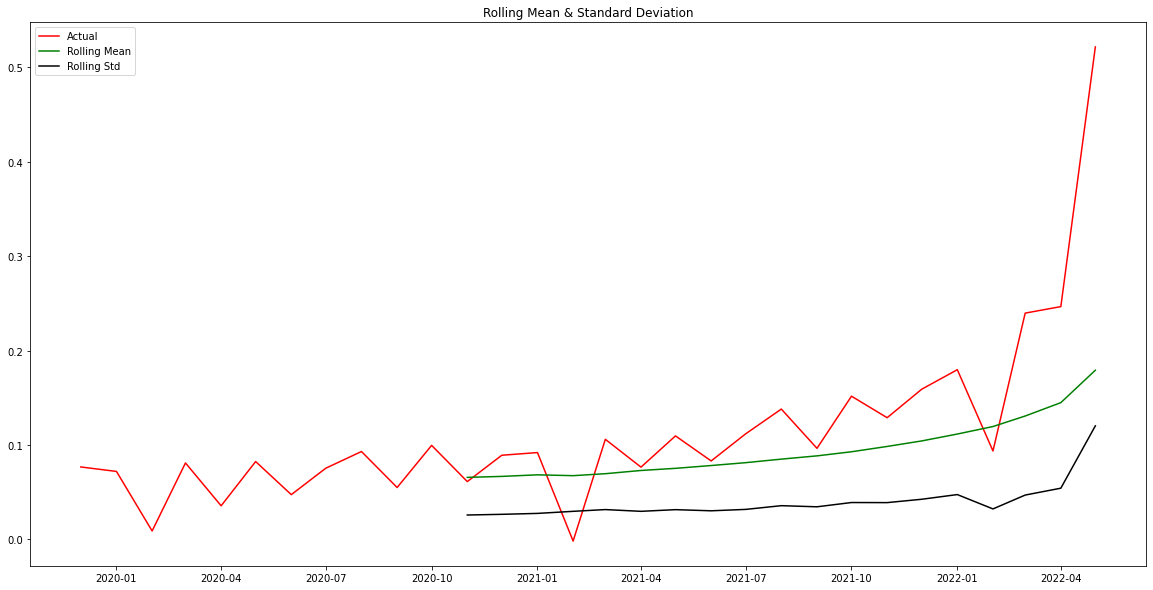

Dickey-Fuller Test: 
Test Statistic           3.060463
p-value                  1.000000
Lags Used                1.000000
No. of Obs              28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
dtype: float64


In [ ]:
# panggil function dan terapkan pada data_log_diff
stationarity(data_log_diff)

Dengan nilai p-value yang masih lebih besar dari 0.05 dan nilai ADF statistic yang lebih besar dari nilai Critical Values pada semua level maka kita masih gagal menolak H0.

Maka, kita dapat mencoba lagi dengan menggunakan Exponentially Weighted Moving Average (function ewm), karena melalui EWM kita dapat memberikan lebih banyak bobot kepada observasi terbaru, dengan kata lain dia akan memberikan bobot lebih sedikit terhadap data yang semakin jauh dari waktu kini, sehingga dia dapat menangkap tren terkini secara lebih cepat

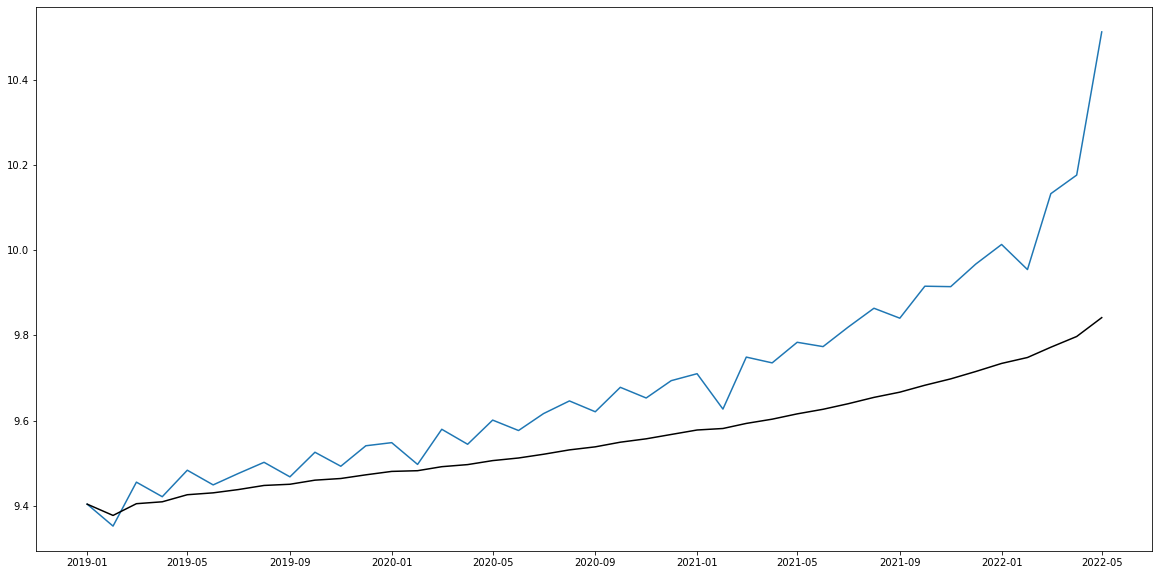

In [ ]:
# Visualisasikan ke dalam bentuk chart 
plt.figure(figsize=(20,10))

# Terapkan function ewm pada data_log melalui variable exp_data
exp_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean() 

plt.plot(data_log)
plt.plot(exp_data, color='black')

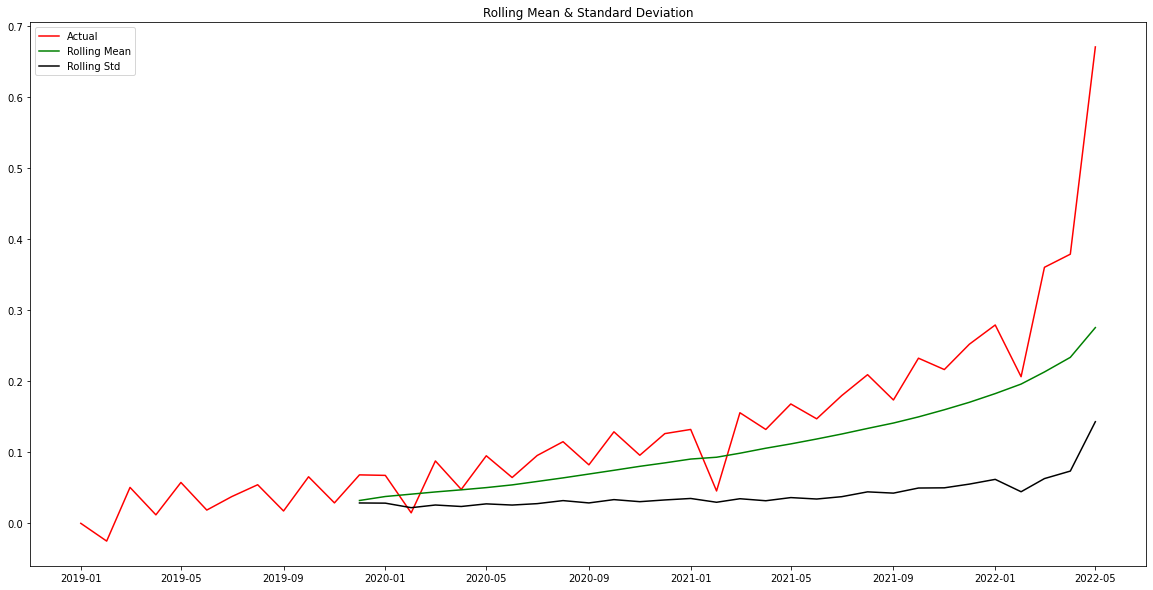

Dickey-Fuller Test: 
Test Statistic           3.489794
p-value                  1.000000
Lags Used                1.000000
No. of Obs              39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
dtype: float64


In [ ]:
# Hitung difference antara data_log dengan exp_data
exp_data_diff=data_log-exp_data

# Panggil function stationarity dan terapkan pada exp_data_diff
stationarity(exp_data_diff)

Dengan nilai p-value yang masih lebih besar dari 0.05 dan nilai ADF statistic yang lebih besar dari nilai Critical Values pada semua level maka kita masih gagal menolak H0. Namun, dikarenakan kita hanya perlu mengetahui gambaran perkembangan 

### Decomposition

Forecasting menggunakan data historikal dimana diurutkan dengan waktu, sehingga goal dari time series model yaitu untuk menemukan waktu dengan trend, seasonality, dan autocorrelation (correlation over time) lalu diformulasikan menjadi sebuah model.

Teknik Decomposition ini digunakan untuk split data time series menjadi beberapa komponen yaitu trend, seasonality, dan noise (residual) components. Setiap komponen dapat digunakan untuk menunjukkan pola (pattern) yang ada di dalam tiap kategori.

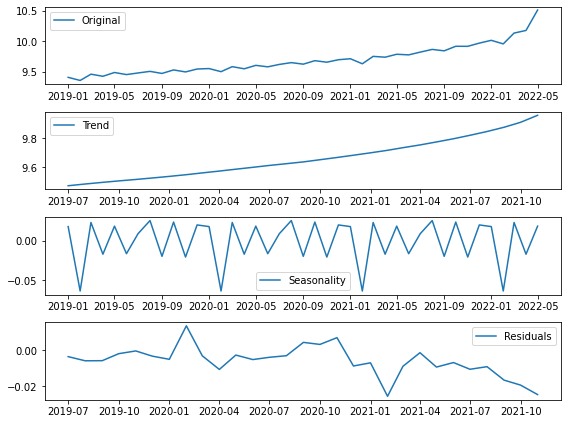

In [ ]:
# panggil function seasonal_decompose () dari statsmodels.tsa yang diterapkan di variabel data_log
decomp=seasonal_decompose(data_log)

# buat variabel trend, seasonal, residual yang sudah diterapkan
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

# Format gambar
plt.figure(figsize = (8,6))
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Dari proses seasonal decompose ditemukan bahwa data kita memiliki tren dan pola seasonality

In [ ]:
# Tampilkan nilai dari tiap kategori dari 18 baris teratas
print("Trend \n",trend.head(18), '\n') # \n untuk menambahkan baris di akhir
print("Seasonal \n",seasonal.head(18), '\n')
print("Residual \n",residual.head(18), '\n')

Trend 
             unique_visitors
month                      
2019-01-01              NaN
2019-02-01              NaN
2019-03-01              NaN
2019-04-01              NaN
2019-05-01              NaN
2019-06-01              NaN
2019-07-01         9.470689
2019-08-01         9.482728
2019-09-01         9.493923
2019-10-01         9.504215
2019-11-01         9.514238
2019-12-01         9.524451
2020-01-01         9.535626
2020-02-01         9.547485
2020-03-01         9.559845
2020-04-01         9.572553
2020-05-01         9.585569
2020-06-01         9.598603 

Seasonal 
             unique_visitors
month                      
2019-01-01         0.017934
2019-02-01        -0.063767
2019-03-01         0.023137
2019-04-01        -0.017094
2019-05-01         0.018516
2019-06-01        -0.016426
2019-07-01         0.008934
2019-08-01         0.025564
2019-09-01        -0.019798
2019-10-01         0.023684
2019-11-01        -0.020714
2019-12-01         0.020031
2020-01-01         0.017934

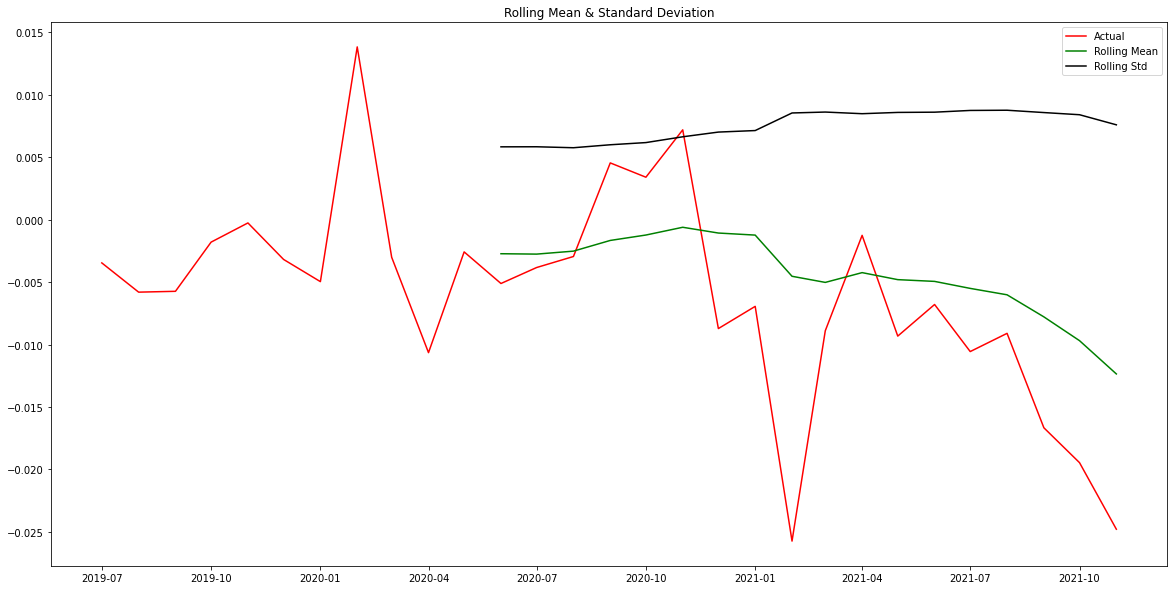

Dickey-Fuller Test: 
Test Statistic          -2.577589
p-value                  0.097718
Lags Used                0.000000
No. of Obs              28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
dtype: float64


In [ ]:
# assign variable baru decomp_data dengan variabel residual di atas
decomp_data=residual

# terapkan function dropna
decomp_data=decomp_data.dropna()

# Panggil function stationarity dan terapkan pada decomp data yang tanpa NA value
stationarity(decomp_data)

Dari komponen data residual, hasil ADF test menunjukkan bahwa bahwa nilai test statistic yg lebih besar daripada critical value pd berbagai tingkat keyakinan dan p-value yang lebih besar dari 0.05, kita dapat menyatakan bahwa series ini tidak stasioner. Namun demikian, dikarenakan kita hanya membutuhkan gambaran perkembangan jumlah kunjungan unik setiap bulannya, kita akan tetap masuk ke tahap pemodelan.

## Product View Dataset

### Descriptive Analysis

In [ ]:
product_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841886 entries, 0 to 841885
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                841886 non-null  int64         
 1   user_id           841886 non-null  object        
 2   session_id        841886 non-null  object        
 3   date_created_at   841886 non-null  datetime64[ns]
 4   traffic_source    841886 non-null  object        
 5   product_id        841886 non-null  int64         
 6   product_name      841886 non-null  object        
 7   product_category  841886 non-null  object        
 8   product_brand     841886 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 64.2+ MB


In [ ]:
print(product_view.filter(['traffic_source', 'product_category', 'product_brand']).describe())
print('-----------------')
print(product_view.filter(['product_name']).describe())

       traffic_source   product_category product_brand
count          841886             841886        841886
unique              5                 36          2757
top             Email  Women's Intimates     Allegra K
freq           377924              62358         28303
-----------------
                                             product_name
count                                              841886
unique                                              27310
top     Wrangler Men's Premium Performance Cowboy Cut ...
freq                                                  277


Dari summary statistic diatas beberapa hal yang dapat kita simpulkan yaitu:

* Traffic source dari banyak pengunjung yaitu email advertising
* Kategori produk paling populer yaitu Women's Intimates
* Brand produk paling populer yaitu Allegra K
* Produk yang paling populer yaitu Wrangler Men's Premium Performance Cowboy Cut ...

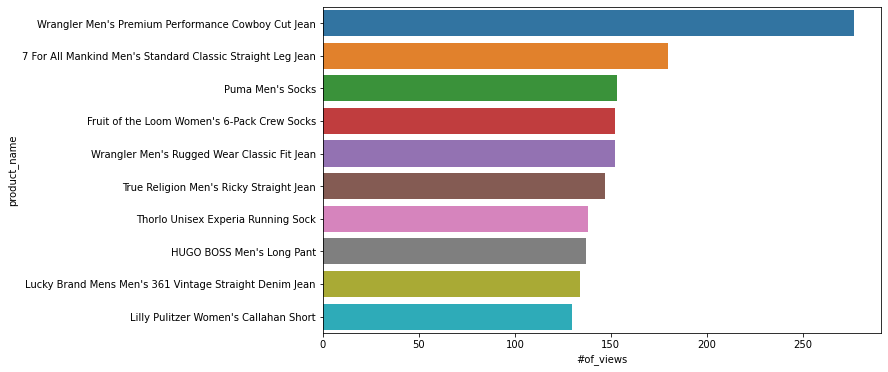

In [ ]:
popular_product = product_view.groupby(['product_name'])['id'].count().nlargest(10).reset_index()
popular_product.columns = ['product_name', '#of_views']
plt.figure(figsize=(10,6))
sns.barplot(data = popular_product, y = 'product_name', x = '#of_views')

Berdasarkan grafik diatas diketahui bahwa 7 dari 10 produk paling populer merupakan produk untuk pria

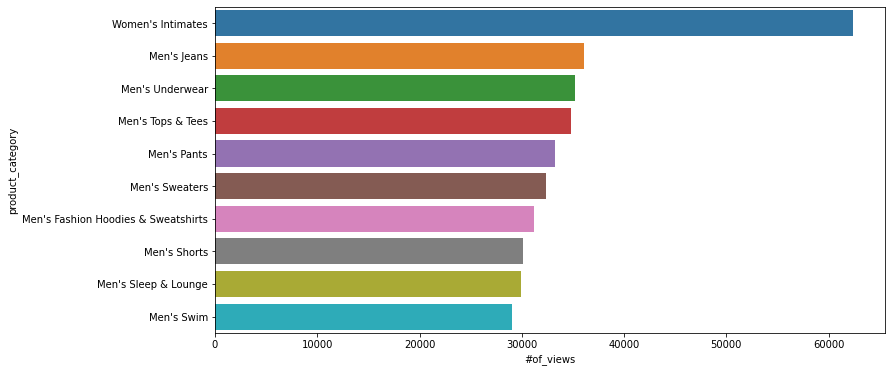

In [ ]:
popular_product_cat = product_view.groupby(['product_category'])['id'].count().nlargest(10).reset_index()
popular_product_cat.columns = ['product_category', '#of_views']
plt.figure(figsize=(12,6))
sns.barplot(data = popular_product_cat, y = 'product_category', x = '#of_views')

Dari visualisasi diatas dapat dilihat 9 dari 10 kategori produk terpopuler merupakan produk untuk pria.

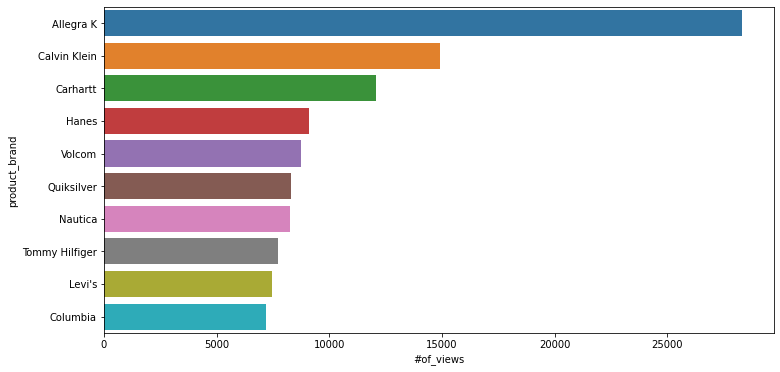

In [ ]:
popular_product_brand = product_view.groupby(['product_brand'])['id'].count().nlargest(10).reset_index()
popular_product_brand.columns = ['product_brand', '#of_views']
plt.figure(figsize=(12,6))
sns.barplot(data = popular_product_brand, y = 'product_brand', x = '#of_views')

Dari visualisasi diatas dapat dilihat bahwa produk Allegra K memiliki popularitas yang melebihi brand lainnya cukup jauh.

# Modeling

## Forecast Perkembangan Jumlah User Baru

Untuk memilih model forecasting yang tepat, kita harus mengetahui karakteristik dari data time series kita.

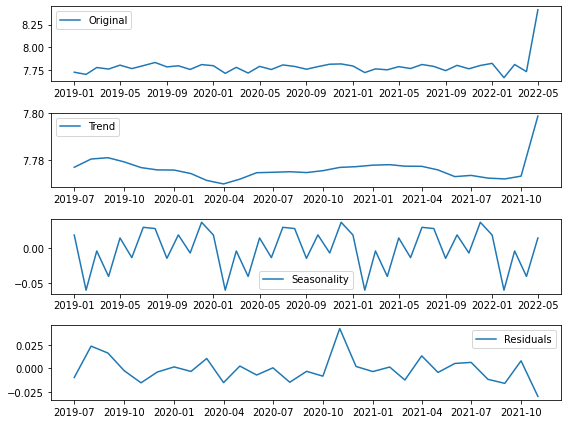

In [ ]:
# panggil function seasonal_decompose () dari statsmodels.tsa yang diterapkan di variabel data_log
data_log=np.log(monthly_new_user) 
decomp=seasonal_decompose(data_log)

# buat variabel trend, seasonal, residual yang sudah diterapkan
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

# Format gambar
plt.figure(figsize = (8,6))
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Dikarenakan data ini memiliki pola musiman, maka model forecasting yang dapat digunakan yaitu model Holt Winter dan SARIMA, dimana kedua model ini cocok untuk digunakan pada data time series yang memiliki tren dan/atau pola musiman. Namun sebelumnya, kita akan membagi data kita menjadi train data dan test data.

In [ ]:
user_train = monthly_new_user[0:36]   #train data sebesar 36 bulan
user_test = monthly_new_user[36:]     #test data sebesar 5 bulan

### Holt Winter’s Exponential Smoothing (HWES)


Holt Winter’s Exponential Smoothing (HWES) juga disebut metode Triple Exponential Smoothing memodelkan langkah waktu berikutnya sebagai fungsi linier berbobot eksponensial dari pengamatan pada langkah waktu sebelumnya, dengan mempertimbangkan tren dan musiman

In [ ]:
model_data = ExponentialSmoothing(user_train['total_new_user'],seasonal_periods=12, seasonal='add').fit(optimized=True)

In [ ]:
data_Holt = user_test.copy() 

In [ ]:
data_Holt['Holt'] = model_data.forecast(len(user_test['total_new_user']))
data_Holt

,total_new_user,Holt
month,,
2022-01-01,2494,2370.662675
2022-02-01,2128,2230.669155
2022-03-01,2462,2371.329447
2022-04-01,2276,2301.006883
2022-05-01,4512,2420.662569


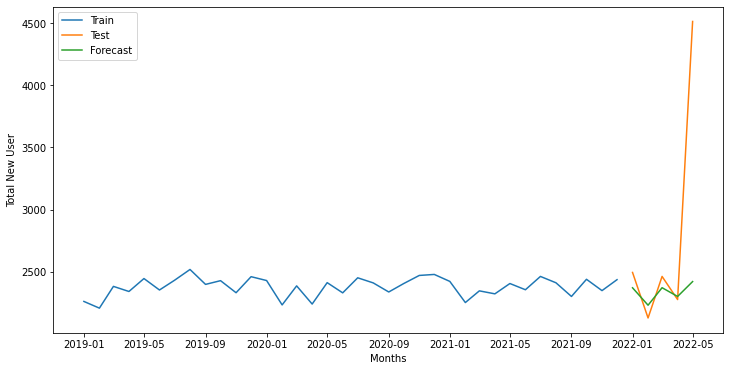

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(user_train['total_new_user'], label='Train')
plt.plot(user_test['total_new_user'], label='Test')
plt.plot(data_Holt['Holt'], label='Forecast')
plt.xlabel('Months')
plt.ylabel('Total New User')
plt.legend(loc=0)

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Metode Seasonal Autoregressive Integrated Moving-Average (SARIMA) memodelkan langkah berikutnya dalam urutan sebagai fungsi linier dari pengamatan yang berbeda, kesalahan, pengamatan musiman yang berbeda, dan kesalahan musiman pada langkah waktu sebelumnya

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
train_log = np.log10(user_train['total_new_user'])

In [ ]:
for param in pdq: #Non-Seasonal
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = temp_model.fit()

            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal #Store the best param values : AIC, P, D, Q [Non-S / Seas]
        except:
            
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 0, 12)12 model - AIC:-201.95724776289617


In [ ]:
mod = sm.tsa.statespace.SARIMAX(train_log,
                                order=(0,1,1),
                                seasonal_order=(1,0,0,12),
                                enforce_stationarity=True)
best_results = mod.fit()

In [ ]:
pred = best_results.get_forecast(steps=5)
pred

In [ ]:
testCopy = user_test.copy()
testCopy['forecast'] = np.power(10, pred.predicted_mean)
testCopy

,total_new_user,forecast
month,,
2022-01-01,2494,2404.825369
2022-02-01,2128,2298.713845
2022-03-01,2462,2357.749167
2022-04-01,2276,2342.763103
2022-05-01,4512,2394.344471


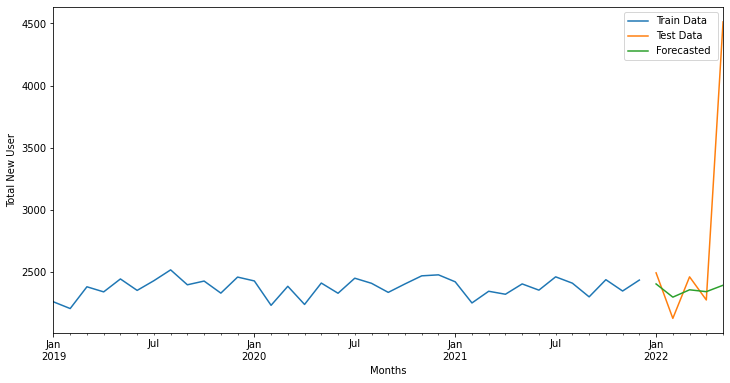

In [ ]:
axis = user_train['total_new_user'].plot(label='Train Data', figsize=(12, 6))
testCopy['total_new_user'].plot(ax=axis, label='Test Data')
testCopy['forecast'].plot(ax=axis, label='Forecasted ')
axis.set_xlabel('Months')
axis.set_ylabel('Total New User')
plt.legend(loc='best')
plt.show()
plt.close()

### Model Evaluation

Untuk menilai performa kedua model forecasting yang digunakan, saya akan menggunakan metrik Mean Absolute Error(MAE), Mean Absolute Percentage Error (MAPE), Mean Square Error (MSE), dan Root Mean Square Error (RMSE).

Model Holt Winter’s Exponential Smoothing (HWES)

In [ ]:
y_true = user_test['total_new_user']
y_pred = data_Holt['Holt']

print('The Mean Absolute Error of our forecasts is ', mean_absolute_error(y_true, y_pred).round(3))
print ('The Mean Absolute Percentage Error of our forecasts is ', mean_absolute_percentage_error(y_true, y_pred).round(3), '%')
print ('The Mean Squared Error of our forecasts is ', mean_squared_error(y_true, y_pred).round(3))
print ('The Root Mean Squared Error of our forecasts is ', np.sqrt(mean_squared_error(y_true, y_pred)).round(3))

The Mean Absolute Error of our forecasts is  486.604
The Mean Absolute Percentage Error of our forecasts is  0.122 %
The Mean Squared Error of our forecasts is  881658.359
The Root Mean Squared Error of our forecasts is  938.967


Model Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [ ]:
y_true = user_test['total_new_user']
y_pred = testCopy['forecast']

print('The Mean Absolute Error of our forecasts is ', mean_absolute_error(y_true, y_pred).round(3))
print ('The Mean Absolute Percentage Error of our forecasts is ', mean_absolute_percentage_error(y_true, y_pred).round(3), '%')
print ('The Mean Squared Error of our forecasts is ', mean_squared_error(y_true, y_pred).round(3))
print ('The Root Mean Squared Error of our forecasts is ', np.sqrt(mean_squared_error(y_true, y_pred)).round(3))

The Mean Absolute Error of our forecasts is  509.712
The Mean Absolute Percentage Error of our forecasts is  0.131 %
The Mean Squared Error of our forecasts is  907377.164
The Root Mean Squared Error of our forecasts is  952.563


Berdasarkan hasil evaluasi diatas, dapat disimpulkan bahwa model Holt Winter memiliki tingkat akurasi yang lebih tinggi dibangingkan model SARIMA. Oleh karena itu, hasil forecasting yang akan digunakan adalah hasil dari model Holt Winter. 

In [ ]:
forecast_predictions = model_data.forecast(steps=17)
forecast_predictions = forecast_predictions[5:]
forecast_predictions

2022-06-01    2345.998930
2022-07-01    2448.000033
2022-08-01    2446.338567
2022-09-01    2345.332114
2022-10-01    2424.002115
2022-11-01    2382.985140
2022-12-01    2457.993833
2023-01-01    2370.662675
2023-02-01    2230.669155
2023-03-01    2371.329447
2023-04-01    2301.006883
2023-05-01    2420.662569
Freq: MS, dtype: float64

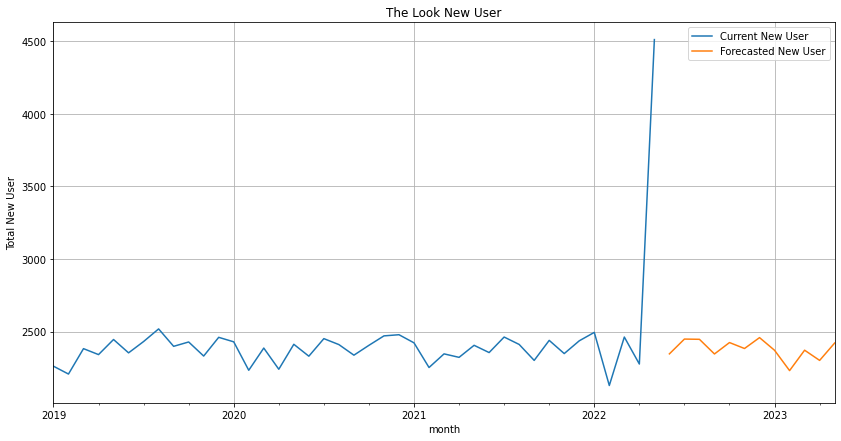

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
plt.ylabel("Total New User")

monthly_new_user['total_new_user'].plot(legend=True,label='Current New User')
forecast_predictions.plot(legend=True,label='Forecasted New User')
plt.title('The Look New User')

plt.grid()
plt.show()

### Combining Current Data and Forecast Data

In [ ]:
monthly_new_user['type'] = 'current'
current_user = monthly_new_user.reset_index()
current_user.tail()

,month,total_new_user,type
36,2022-01-01,2494,current
37,2022-02-01,2128,current
38,2022-03-01,2462,current
39,2022-04-01,2276,current
40,2022-05-01,4512,current


In [ ]:
fc_df = forecast_predictions.to_frame().reset_index() 
fc_df.columns = ['month', 'total_new_user']
fc_df['type'] = 'forecast'
fc_df.head()

,month,total_new_user,type
0,2022-06-01,2345.998930,forecast
1,2022-07-01,2448.000033,forecast
2,2022-08-01,2446.338567,forecast
3,2022-09-01,2345.332114,forecast
4,2022-10-01,2424.002115,forecast


In [ ]:
user_result = pd.concat([current_user, fc_df])
user_result.reset_index()
user_result.head()

,month,total_new_user,type
0,2019-01-01,2261.0,current
1,2019-02-01,2207.0,current
2,2019-03-01,2382.0,current
3,2019-04-01,2341.0,current
4,2019-05-01,2445.0,current


In [ ]:
user_result.to_csv(r'user result.csv', index = False)

## Forecast Perkembangan Jumlah Unique Visitor 

Untuk memilih model forecasting yang tepat, kita harus mengetahui karakteristik dari data time series kita.

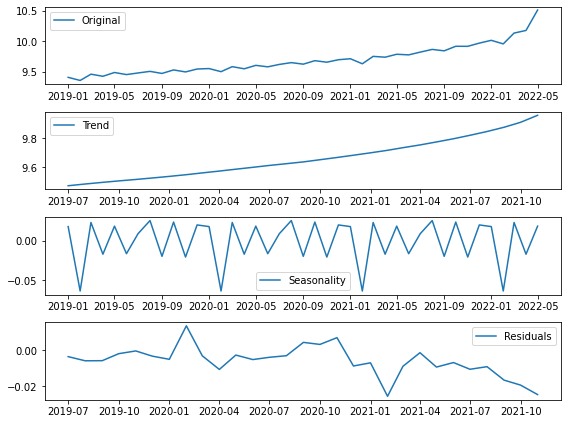

In [ ]:
# panggil function seasonal_decompose () dari statsmodels.tsa yang diterapkan di variabel data_log
data_log=np.log(unique_visitors) 
decomp=seasonal_decompose(data_log)

# buat variabel trend, seasonal, residual yang sudah diterapkan
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

# Format gambar
plt.figure(figsize = (8,6))
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Dikarenakan data ini memiliki tren positif dan pola musiman, maka model forecasting yang dapat digunakan yaitu model Holt Winter dan SARIMA, dimana kedua model ini cocok untuk digunakan pada data time series yang memiliki tren dan/atau pola musiman. Namun sebelumnya, kita akan membagi data kita menjadi train data dan test data.

In [ ]:
event_train = unique_visitors[0:36]   #train data sebesar 36 bulan
event_test = unique_visitors[36:]     #test data sebesar 5 bulan

### Holt Winter’s Exponential Smoothing (HWES)


Holt Winter’s Exponential Smoothing (HWES) juga disebut metode Triple Exponential Smoothing memodelkan langkah waktu berikutnya sebagai fungsi linier berbobot eksponensial dari pengamatan pada langkah waktu sebelumnya, dengan mempertimbangkan tren dan musiman

In [ ]:
model_data = ExponentialSmoothing(event_train['unique_visitors'],seasonal_periods=12, seasonal='add', trend='mul').fit(optimized=True)

In [ ]:
data_Holt = event_test.copy() 

In [ ]:
data_Holt['Holt'] = model_data.forecast(len(event_test['unique_visitors']))
data_Holt

,unique_visitors,Holt
month,,
2022-01-01,22325,20798.359717
2022-02-01,21049,19618.099294
2022-03-01,25150,21235.791851
2022-04-01,26271,20931.083520
2022-05-01,36756,21935.333339


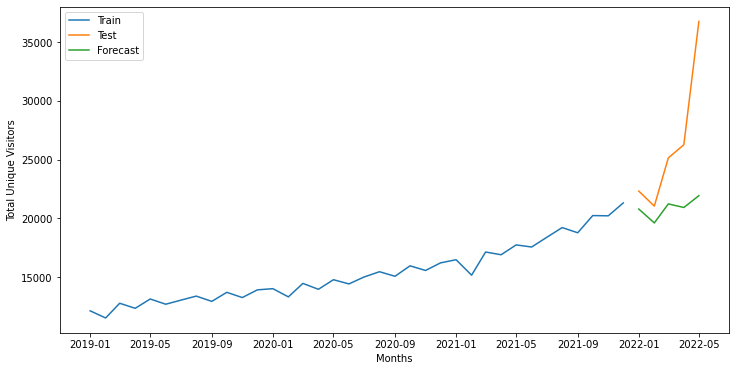

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(event_train['unique_visitors'], label='Train')
plt.plot(event_test['unique_visitors'], label='Test')
plt.plot(data_Holt['Holt'], label='Forecast')
plt.xlabel('Months')
plt.ylabel('Total Unique Visitors')
plt.legend(loc=0)

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Metode Seasonal Autoregressive Integrated Moving-Average (SARIMA) memodelkan langkah berikutnya dalam urutan sebagai fungsi linier dari pengamatan yang berbeda, kesalahan, pengamatan musiman yang berbeda, dan kesalahan musiman pada langkah waktu sebelumnya

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
train_log = np.log10(event_train['unique_visitors'])

In [ ]:
for param in pdq: #Non-Seasonal
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = temp_model.fit()

            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal #Store the best param values : AIC, P, D, Q [Non-S / Seas]
        except:
            
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 0)x(1, 0, 0, 12)12 model - AIC:-217.54560766365694


In [ ]:
mod = sm.tsa.statespace.SARIMAX(train_log,
                                order=(0,1,0),
                                seasonal_order=(1,0,0,12),
                                enforce_stationarity=True)
best_results = mod.fit()

In [ ]:
pred = best_results.get_forecast(steps=5)
pred

In [ ]:
testCopy = event_test.copy()
testCopy['forecast'] = np.power(10, pred.predicted_mean)
testCopy

,unique_visitors,forecast
month,,
2022-01-01,22325,21656.262866
2022-02-01,21049,20005.170956
2022-03-01,25150,22477.711605
2022-04-01,26271,22188.171705
2022-05-01,36756,23236.466800


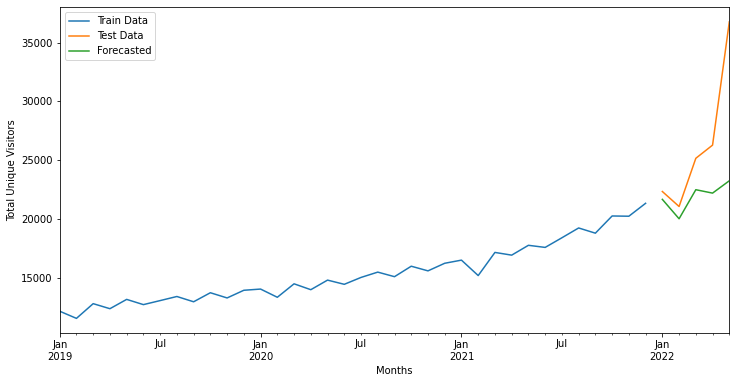

In [ ]:
axis = event_train['unique_visitors'].plot(label='Train Data', figsize=(12, 6))
event_test['unique_visitors'].plot(ax=axis, label='Test Data')
testCopy['forecast'].plot(ax=axis, label='Forecasted')
axis.set_xlabel('Months')
axis.set_ylabel('Total Unique Visitors')
plt.legend(loc='best')
plt.show()
plt.close()

### Model Evaluation

Untuk menilai performa kedua model forecasting yang digunakan, saya akan menggunakan metrik Mean Absolute Error(MAE), Mean Absolute Percentage Error (MAPE), Mean Square Error (MSE), dan Root Mean Square Error (RMSE).

Model Holt Winter’s Exponential Smoothing (HWES)

In [ ]:
y_true = event_test['unique_visitors']
y_pred = data_Holt['Holt']

print('The Mean Absolute Error of our forecasts is ', mean_absolute_error(y_true, y_pred).round(3))
print ('The Mean Absolute Percentage Error of our forecasts is ', mean_absolute_percentage_error(y_true, y_pred).round(3), '%')
print ('The Mean Squared Error of our forecasts is ', mean_squared_error(y_true, y_pred).round(3))
print ('The Root Mean Squared Error of our forecasts is ', np.sqrt(mean_squared_error(y_true, y_pred)).round(3))

The Mean Absolute Error of our forecasts is  5406.466
The Mean Absolute Percentage Error of our forecasts is  0.18 %
The Mean Squared Error of our forecasts is  53573200.219
The Root Mean Squared Error of our forecasts is  7319.372


In [ ]:
y_true = event_test['unique_visitors']
y_pred = testCopy['forecast']

print('The Mean Absolute Error of our forecasts is ', mean_absolute_error(y_true, y_pred).round(3))
print ('The Mean Absolute Percentage Error of our forecasts is ', mean_absolute_percentage_error(y_true, y_pred).round(3), '%')
print ('The Mean Squared Error of our forecasts is ', mean_squared_error(y_true, y_pred).round(3))
print ('The Root Mean Squared Error of our forecasts is ', np.sqrt(mean_squared_error(y_true, y_pred)).round(3))

The Mean Absolute Error of our forecasts is  4397.443
The Mean Absolute Percentage Error of our forecasts is  0.142 %
The Mean Squared Error of our forecasts is  41625035.705
The Root Mean Squared Error of our forecasts is  6451.747


Berdasarkan hasil evaluasi diatas, dapat disimpulkan bahwa model Holt Winter memiliki tingkat akurasi yang lebih rendah dibangingkan model SARIMA. Oleh karena itu, hasil forecasting yang akan digunakan adalah hasil dari model SARIMA.

In [ ]:
pred = best_results.get_forecast(steps=13)
n_steps = 13
idx = pd.date_range(unique_visitors.index[-1], periods=n_steps, freq='MS')
fc = pd.DataFrame(np.column_stack([np.power(10, pred.predicted_mean)]), 
                     index=idx, columns=['forecast'])
fc = fc.drop(index = '2022-05-01')
fc

,forecast
2022-06-01,20005.170956
2022-07-01,22477.711605
2022-08-01,22188.171705
2022-09-01,23236.466800
2022-10-01,23012.467536
2022-11-01,24037.794119
2022-12-01,25078.545779
2023-01-01,24525.979772
2023-02-01,26348.692744
2023-03-01,26322.571803


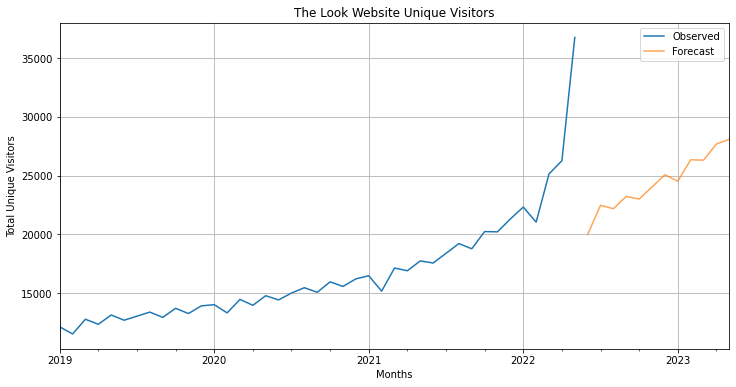

In [ ]:
axis = unique_visitors['unique_visitors'].plot(label='Observed', figsize=(12, 6))
fc['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.set_xlabel('Months')
axis.set_ylabel('Total Unique Visitors')
plt.legend(loc='best')
plt.title("The Look Website Unique Visitors")
plt.grid()
plt.show()

### Combining Current Data and Forecast Data

In [ ]:
unique_visitors['type'] = 'current'
current_event = unique_visitors.reset_index()
current_event.head()

,month,unique_visitors,type
0,2019-01-01,12141,current
1,2019-02-01,11532,current
2,2019-03-01,12784,current
3,2019-04-01,12355,current
4,2019-05-01,13147,current


In [ ]:
fce_df = fc.reset_index() 
fce_df.columns = ['month', 'unique_visitors']
fce_df['type'] = 'forecast'
fce_df.head()

,month,unique_visitors,type
0,2022-06-01,20005.170956,forecast
1,2022-07-01,22477.711605,forecast
2,2022-08-01,22188.171705,forecast
3,2022-09-01,23236.466800,forecast
4,2022-10-01,23012.467536,forecast


In [ ]:
event_result = pd.concat([current_event, fce_df])
event_result.reset_index()
event_result.tail()

,month,unique_visitors,type
7,2023-01-01,24525.979772,forecast
8,2023-02-01,26348.692744,forecast
9,2023-03-01,26322.571803,forecast
10,2023-04-01,27687.980180,forecast
11,2023-05-01,28103.884714,forecast


In [ ]:
event_result.to_csv(r'event_result.csv', index = False)